# EX 1

Yehonatan Ezra

## Question 2 - Network Robustness and Phase Transitions

### 2.0 - Helper Module for Network Robustness

This module defines a set of reusable functions for computing
p∞, generating adversarial attack orders, plotting robustness curves,
and removing nodes from a graph. Question-specific wrappers
(e.g., `question211`, `question212`, …) import these helpers
to produce the final plots with minimal boilerplate.

In [ ]:
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import List
from google.colab import files


def compute_p_inf(graph, mode):
    """ Return the relative size of the largest connected component. """
    if not graph or len(graph) == 0:
        return 0.0
    if mode == "wcc":
        largest_connected_components = max(nx.weakly_connected_components(graph), key=len)
    else:
        largest_connected_components = max(nx.connected_components(graph), key=len)

    return len(largest_connected_components) / graph.number_of_nodes()


def attack_order(G, strategy, k_bet=60):
    """  Pre-compute an ordered list of nodes that will be removed from G."""
    if strategy == 'random':
        return np.random.permutation(list(G.nodes()))
    if strategy == 'highest degree to lowest':
        return [v for v, _ in sorted(G.degree,key=lambda x: x[1], reverse=True)]
    if strategy == 'betweenness':
        bc = nx.betweenness_centrality(G, k=k_bet)

        return sorted(bc, key=bc.get, reverse=True)

    raise ValueError(f"unknown strategy: {strategy}")


def robustness_curve(G_base, f_values, order):
    """Remove nodes cumulatively and store p_inf for every f."""
    g = G_base.copy()
    p_inf, next_idx, N = [], 0, g.number_of_nodes()
    for f in f_values:
        target = int(f * N)
        while next_idx < target:
            g.remove_node(order[next_idx])
            next_idx += 1
        mode = 'wcc' if isinstance(g, nx.DiGraph) else 'scc'
        p_inf.append(compute_p_inf(g, mode))

    return p_inf


def remove_nodes(f_values, G_base, strategy, *, k_bet=60):
    """  Convenience wrapper around :func:`_robustness_curve`.
    Calls :func:`_attack_order` to build the removal order and then
    feeds everything into :func:`_robustness_curve`.
    """
    order = attack_order(G_base, strategy, k_bet)

    return robustness_curve(G_base, f_values, order)


def create_plot (size_w, size_h,title, f_values, p_inf_1,label1=None, p_inf_2=None, label2=None):
    """Simple helper to plot one or two robustness curves."""
    plt.figure(figsize=(size_w, size_h))
    plt.plot(f_values, p_inf_1, marker='o', linestyle='-', label=label1)

    if p_inf_2 is not None:
        plt.plot(f_values, p_inf_2, marker='s', linestyle='-', label=label2)

    plt.title(title)
    plt.xlabel("Fraction of nodes removed (f)")
    plt.ylabel("p∞ - Fraction in largest connected component")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()

    plt.show()

### 2.1 Robustness in Grids

#### 2.1.1 Two Dimensional Grids
[

In [ ]:
def question211(dim_size):
    """ The main function for question 2.1.1 """
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.grid_2d_graph(dim_size, dim_size)
    mapping = {node: index for index, node in enumerate(G_base.nodes())}
    G_base = nx.relabel_nodes(G_base, mapping)
    p_inf_values = remove_nodes(f_values, G_base, 'random')
    create_plot(8, 5,"Robustness Curve for 2D Grid (100x100)", f_values, p_inf_values, )

question211(100)


 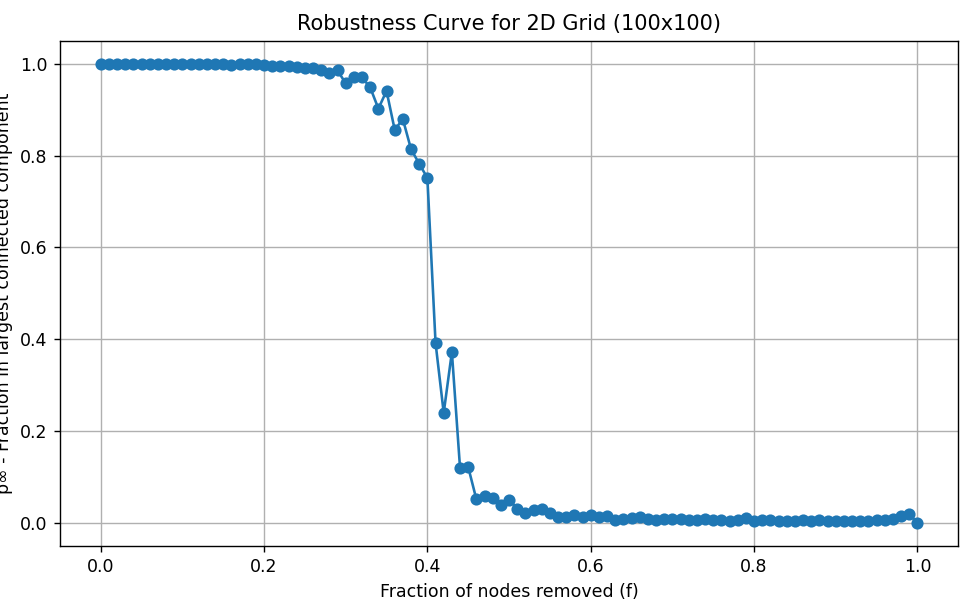Observations and Analysis:

As shown in the graph, when F is small (for example 0.1-0.2) most of the network stay conected, and P-infinity remains close to 1.
But when F gets close to 0.4, the network suddenly break apart and P-infinity drops quickly.
We can also see some small variations in the curve because the removal is random, but the overall pattern is clear, and we can easily observe the phase transition.

#### 2.1.2 Higher Dimensional Grids


 My initial predicting:

 Since the average node in a 3D grid has more neighbors, I expect the network to stay connected for longer.# That means the phase transition will happen at a higher value of f compared to the 2D grid.
 Let's see if I'm right...


In [ ]:
def question212(dim_size):
    """ The main function for question 2.1.2 """
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.grid_graph(dim=[dim_size, dim_size, dim_size])
    mapping = {}
    for index, node in enumerate(G_base.nodes()):
        mapping[node] = index
    G_base = nx.relabel_nodes(G_base, mapping)
    p_inf_values = remove_nodes(f_values, G_base , 'random')
    create_plot(8, 5,"Robustness Curve for 3D Grid (20x20x20)", f_values, p_inf_values, )

question212(20)

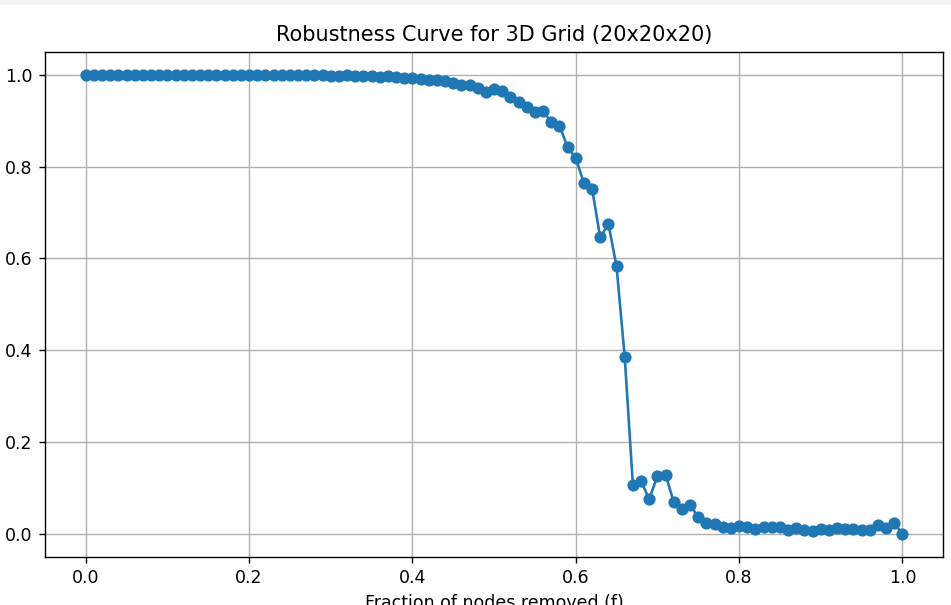


As expected, the network stayed connected for a larger range of F values compared to the 2D grid.
The phase transition now happended around F~0.6 which is much higher then in the 3D case (where it was close to 0.4.

### 2.2 Robustness in Erdős–Rényi Graphs

#### 2.2.1 Random Node Removal

In [ ]:

def question221(n , k_avg):
    """ The main function for question 2.2.1 """
    p = k_avg / (n - 1)
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.erdos_renyi_graph(n, p)
    p_inf_values = remove_nodes(f_values, G_base, 'random')
    create_plot(8 ,  5,"Robustness Curve – ER Graph (n=2000, <k>=4)", f_values, p_inf_values, )

question221(2000 , 4)

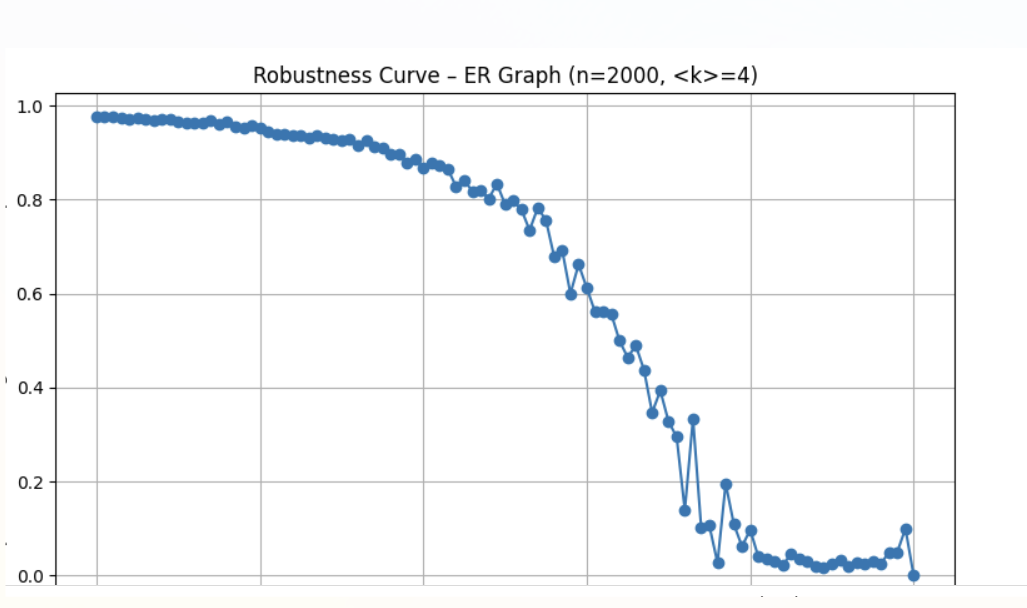
As shown in the Graph, the network remained mostly connected for small values of F with P-infinity close to 1.
As F increased, the network fradually broke apart and P-infinity decreased smoothly.
Unlike grid networks, there was no sharp phase transition, the decline was continuous and expected for ER graphs, which are randomly structured and do not rely on specific hub node.

#### 2.2.2 Adversarial Node Removal

In [ ]:
def question222(n, k_avg):
    """ The main function for question 2.2.2 """
    p = k_avg / (n - 1)
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.erdos_renyi_graph(n, p)
    p_inf_values = remove_nodes(f_values, G_base,'highest degree to lowest')
    create_plot(8, 5,"Q.2.2.2 - Adversarial Robustness – ER Graph (n=2000, <k>=4)", f_values, p_inf_values, )

question222(2000 , 4)

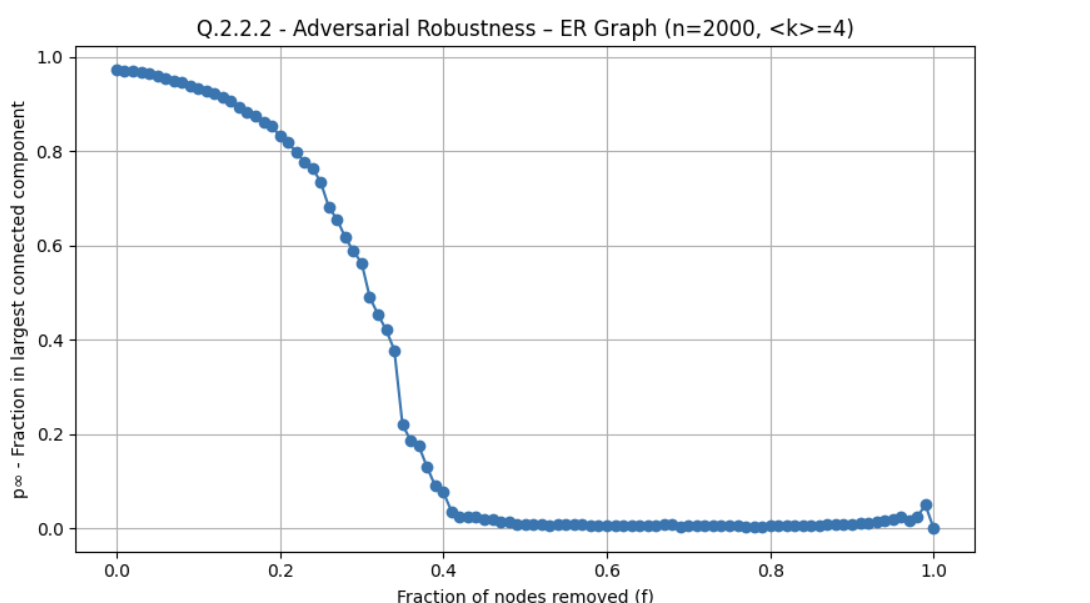
As shown in the plot, p-infinity drops much faster compared to the random removal scenario.
The network starts to fragment after removing just 10–20% of the nodes, and the phase transition occurs around f ≈ 0.35–0.4.
This is significantly earlier than in the random case, where the network degraded gradually over a wider range of f values.
These results confirm that ER networks are much more vulnerable to targeted attacks.
Removing a small number of highly connected nodes is enough to break down the largest connected component and disconnect the network.

### 2.3 Robustness of Real World Networks

In this part, I chose the network "email.edgelist".

In [ ]:

def question230(filepath: str):
    uploaded = files.upload()
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.read_edgelist(filepath, create_using=nx.DiGraph(), nodetype=int)
    p_inf_values_random = remove_nodes(f_values, G_base,'random')
    p_inf_values_adversarial = remove_nodes(f_values, G_base,'highest degree to lowest')
    create_plot(8, 5,"Q3 – Robustness of Email Network (Directed, WCC)",
        f_values, p_inf_values_random,"Random Removal",p_inf_values_adversarial,
        "Adversarial Removal")

question230("email.edgelist.txt")


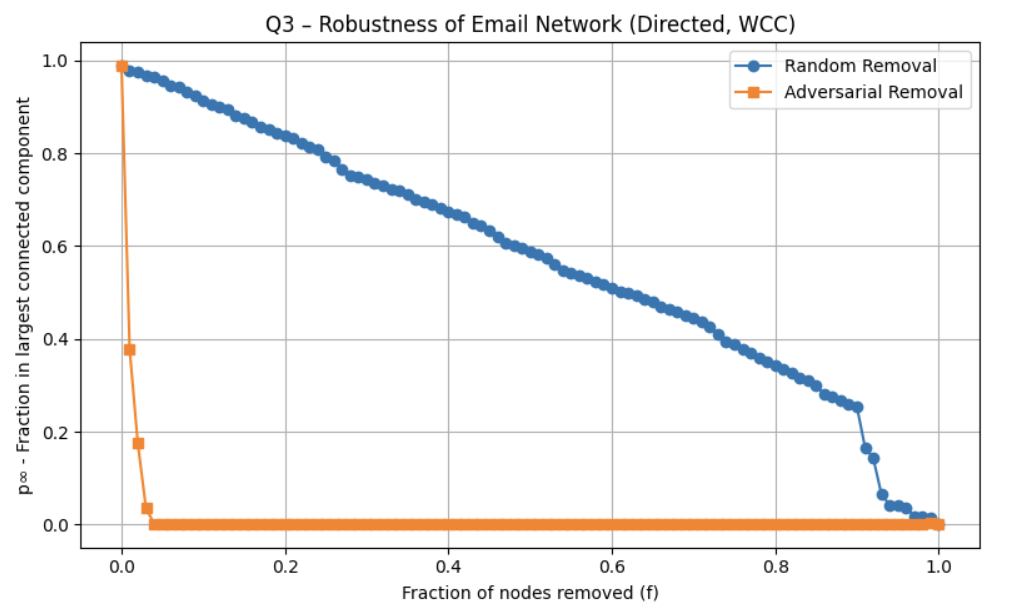

Explanation:

In this analysis, we evaluated the robustness of a real-world email network by examining how the size of the largest weakly connected component (p∞) changes as nodes are removed.
The results show a clear distinction between random and adversarial node removal:

- Under random removal, the network gradually loses connectivity. Even after removing 50% of the nodes, a large connected component still exists. This indicates that the network is fairly robust to random failures.
  
- Under adversarial removal (removing the highest-degree nodes first), the network collapses almost immediately. Just a small fraction of node removals is enough to fragment the network and reduce p∞ to near zero.

These results highlight the vulnerability of the network to targeted attacks and the importance of high-degree nodes (hubs) in maintaining overall connectivity.

Compared to the Erdős-Rényi (ER) model, the email network behaves quite differently. ER graphs have a uniform degree distribution, meaning that random and adversarial removals tend to affect the network in a similar, gradual way. In contrast, the email network relies heavily on a small number of high-degree hubs, making it significantly more vulnerable to targeted attacks while remaining resilient to random failures.

#### 2.3.1 Adversarial Strategies

In [ ]:
def question231(filepath: str):
    """This main function for question 3.1:
     Compare betweenness vs. degree-based adversarial attack """
    f_values = np.arange(0.0, 1.01, 0.01)
    G_base = nx.read_edgelist(filepath, create_using=nx.DiGraph(), nodetype=int)
    p_inf_adversarial = remove_nodes(f_values, G_base, 'highest degree to lowest')
    p_inf_betweenness = remove_nodes(f_values, G_base, 'betweenness')
    create_plot(8, 5, "Q3.1 – Adversarial Strategy Comparison (Betweenness vs Degree)",
        f_values, p_inf_adversarial, "Degree-Order Removal", p_inf_betweenness,
        "Betweenness-Order Removal")

question231("email.edgelist.txt")

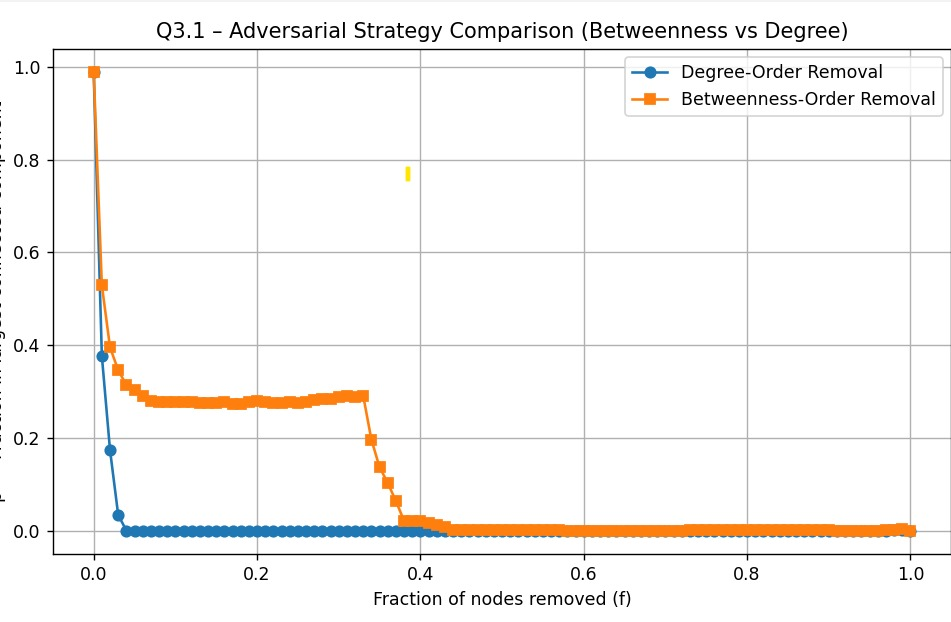
Explanation:

In this question, I continued to analyze the same email communication network used in the previous section. I compared two adversarial node-removal strategies:

1) Degree-order removal - delete nodes from highest to lowest degree.

2) Betweenness-order removal (my proposed alternative) - delete nodes ranked by betweenness centrality.

The degree-based attack dismantled the giant weakly-connected component after deleting only ≈ 4 % of the nodes, whereas the betweenness-based attack needed ≈ 38 % to achieve the same effect.
This large gap reveals a hub-dominated topology: a handful of very high-degree accounts act as critical broadcast centres, so removing them fragments the network almost immediately. Betweenness-based attacks are usually superior in bridge-centred, modular graphs, but in this network they waste early deletions on medium-degree nodes and are therefore less efficient.



## Question 3 - Stub Matching

### 3.1 Sample Pseudographs

This is an implementation of `sample_CM_stub_matching(deg_seq)` which, given a degree sequence (a list of non-negative integers), constructs a uniformly sampled undirected pseudograph via the classic stub-matching algorithm.


In [ ]:
import random
import networkx as nx
from typing import List

def sample_CM_stub_matching(deg_seq: List[int]) -> nx.MultiGraph:
    """This function is the main function for question 3.1.
    sample an undirected pseudograph with the given degree sequence via stub matching.
    Returns a MultiGraph that may include loops and parallel edges."""
    if not deg_seq:
        raise ValueError("deg_seq is empty")
    if sum(deg_seq) % 2 == 1:
        raise ValueError("Degree sum must be even")

    # 1. build stub list
    stubs = [node for node, k in enumerate(deg_seq) for _ in range(k)]
    random.shuffle(stubs)                # uniform random permutation

    # 2. pair consecutive stubs
    G = nx.MultiGraph()
    G.add_nodes_from(range(len(deg_seq)))
    for u, v in zip(stubs[::2], stubs[1::2]):
        G.add_edge(u, v)

    return G

### 3.2 Rejection Sampling

Explanation:

This code implements **sample_CM_stub_matching_no_multiple()**, which repeatedly calls the pseudograph sampler **sample_CM_stub_matching()** (That I implemented in question 3.1) and uses the helper **is_simple()** to reject any graph containing self-loops or parallel edges, returning the first simple graph that matches the given degree sequence.



In [ ]:
from collections import Counter

def is_simple(G: nx.MultiGraph) -> bool:
    for u, v in G.edges():
        if u == v or G.number_of_edges(u, v) > 1:
            return False
    return True

def sample_CM_stub_matching_no_multiple(deg_seq: List[int], max_attempts = None) -> nx.MultiGraph:
    """
    Repeat stub-matching until a simple graph (no loops, no parallel edges)
    is produced. Return (G_simple, n_rejects).
    """

    n_rejects = 0
    while True:
        G_multi = sample_CM_stub_matching(deg_seq)
        if is_simple(G_multi):
            # convert to simple Graph
            G = nx.Graph()
            G.add_nodes_from(G_multi.nodes())
            G.add_edges_from(G_multi.edges())
            return G, n_rejects
        n_rejects += 1

        if max_attempts and n_rejects == max_attempts:
            return None, n_rejects


### 3.3 Power Law Degree Sequence

This code is the implemention of **power_law_deg_seq()**:


In [ ]:
import numpy as np
import networkx as nx
from typing import List

def power_law_deg_seq(size_graph: int, exponent: float) -> List[int]:
    k_vals = np.arange(1, size_graph, dtype=float)
    pk = k_vals ** (-exponent)
    pk /= pk.sum()
    while True:
        seq = np.random.choice(k_vals, size=size_graph, p=pk).astype(int)
        if seq.sum() % 2 != 0:
            continue
        if nx.is_graphical(seq, method='eg'):
            return seq.tolist()






### 3.4 Effect of Degree Sequence on Number of Rejections

In [ ]:
import matplotlib.pyplot as plt

def analyze_rejections_powerlaw(n, alpha, samples):
    variances = []
    rejects   = []
    for _ in range(samples):
      seq   = power_law_deg_seq(n, alpha)
      G, nr = sample_CM_stub_matching_no_multiple(seq, 10000)
      if not G:
        continue
      variances.append(np.var(seq))
      rejects.append(nr)

    plt.figure(figsize=(6,4))
    plt.scatter(variances, rejects)
    plt.xlabel("Degree variance σ²")
    plt.ylabel("Number of rejections")
    plt.title(f"Q3.4 – Rejections vs. variance (n={n}, α={alpha})")
    plt.grid(True)
    plt.show()

    # Compute correlations
    r = np.corrcoef(variances, rejects)[0,1]
    print(f"Pearson r = {r:.3f}")



analyze_rejections_powerlaw(20, 2.0, 50)


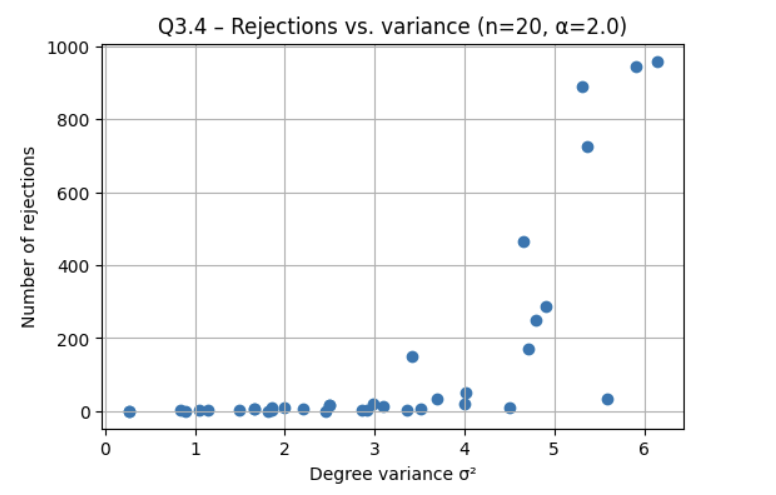

Explanation:

As seen in the graph, I found a strong correlation between the variance of the degree sequence and the number of rejections:

Sequences with low variance (below 4) typically resulted in a valid graph within a few attempts. In contrast, sequences with high variance (above 4) required thousands of rejections, sometimes reaching the maximum threshold of 10,000 attempts.  
(In some cases, the number of rejections exceeded this threshold, but those cases were skipped and not counted — you can see this in the implementation of the `sample_CM_stub_matching_no_multiple` function.)

This behavior occurs because high-variance degree sequences often contain a few nodes with very high degrees (hubs), while most nodes have low degrees. During stub-matching, these high-degree nodes are more likely to form self-loops or multiple edges, which are not allowed in simple graphs. As a result, such configurations are rejected repeatedly, increasing the number of rejections significantly.


## Question 4 - Edge Swapping

### 4.1 Stationary Distribution in the Naive Edge-Swapping Algorithm


##### **Algorithm 1 converge to a uniform distribution**
In Algorithm 1, we increment the step counter i only when we have a valid swap,so this ensures that each step corresponds to a real change in the graph and every valid graph with the same degree sequence is reachable from every other grapth via valid swaps. so these conditions guarantee that the chain converges to the uniform distribution over the space of all valid grapth with the give degree sequence.

###### provement:

Let A be a set of all simple directed graphs (without self loops or multuiple edges) with n nodes and with a fixed in-degree and out-degree sequence:

K_out = (d1_out, ..., dn_out)
K_in = (d1_in, ..., dn_in).

Let define a markov chain M over the state space A, where transition are made like algorithem 1 (only stemps where a valid swap is performed are counted toward the total number of steps).

let G1, G2 to be an arbitrary graphs of A.
We now show that M satisfies the three required properties: Irreducibility, Aperiodicity and Symmetry.

Irreducibility: Because our algorithm (Algorithm 1) only performs valid swaps and does not increment the step counter i when a swap is invalid, it ensures that each step corresponds to a meaningful transition between graphs that maintain the degree sequence.
It is a known result in the configuration model literature that the space
A — the set of all simple directed graphs with a given degree sequence is connected under valid edge swaps. This means that for any 2 grapsh g1 and g2 there exists a finite sequence of valid edge swaps that transofrm g1 into g2 where each intermediate graph also belongs to A.Therefore, every state in the chain is reachable from any other, and the chain is irreducible.


Aperiodicity: There is a nonzero probability of choosing two edges such that the swap is invalid. So in this case, the graph remains unchanged.
Therefore, the chain has self-loops and does not get "stuck" in periodic cycles. This ensures the chain is aperiodic.

Symmetry: The transition from a graph G1 to G2 occurs only via a specific edge swap. Since the pair of the edges is chosen uniformly at random, and the swap is valid in both direction, the probability to moving from g1 to g2 is equal to the probability of moving from g2 to g1.

Since out Markob chain is irreducible, aperiodic and symetry, it follows from standard results in Markov chain theory that The uniform distribution over the state space A is the unique stationary distribution of the chain, so its means that as the number of steps goes to infinity, the probability of being in any particular graph g that bellongs to A converges to 1/|A| -> uniform distribution.

**Algorithm 2 doesn't converge to a uniform distribution**

In Algorithm 2, we increment the step counter i regardless of whether the swap was valid.
This introduces a bias,i f the current graph is in a state where many swaps are invalid (e.g., because most swaps would create multiple edges), the chain will spend more steps in that state, so that state (graph) appreats more often in the output, so the distirubution cant not be uniform.

**The minimal example from the class -  k_in = (1, 1,2) and k_out = (2,1,1):**

let be G1, G2, G3, G4, G5 graph like this:

G1:
(1 -> 2), (2 -> 3), (3 -> 3), (3 -> 1)

G2: (2 -> 2), (3 -> 1), (1 -> 3), (3 -> 3)

G3: (1 -> 3), (3 -> 2), (2 -> 3), (3 -> 1)

G4: (1 -> 1), (3 -> 3), (3 -> 2), (2 -> 3)

G5: (3 -> 3), (3 -> 2), (2 -> 1), (1 -> 3)


With algorithm 1, every graph could be the output with uniform distribution so P(G1)= P(G2) =P(G3)=P(G4) = P(G5) = 1\5.

But with algorithm 2, if we run this algorithm for 10,000 steps we will get that the frequency of G1 is 1700 but G2 is 2200 ( and G3 is totaly different - 3000). so its easy to see that P(G1)!=P(G2)!=P(G3).





### 4.2 Edge Swapping With No Self Edges

Disallowing self-loops restricts the Markov chain to a smaller state space and could creat asymmetry in the Markov chain. for exampl: a swap from graph A to graph B may be allowed but the reveerse swap may be forbidden if it creates a self loop, so some graphs may become more likely then others, and the chain does not convergence to the uniform distirbution.

We can fix it by ensure Ensure that all allowed swaps are reversible and that steps are only counted when valid transitions occur. This maintains symmetry and restores uniform convergence.

### 4.3 Implementing MCMC in Code

In [ ]:
import random
import networkx as nx
from collections import Counter
import pandas as pd

def CM_MCMC(G: nx.DiGraph, T: int) -> nx.DiGraph:
  G = G.copy()
  edges = list(G.edges())

  for _ in range(T):
      # Randomly select two distinct edges
      e1, e2 = random.sample(edges, 2)
      u1, v1 = e1
      u2, v2 = e2
      new_e1 = (u1, v2)
      new_e2 = (u2, v1)
      edges.remove(e1)
      edges.remove(e2)
      edges.append(new_e1)
      edges.append(new_e2)

  new_G = nx.MultiDiGraph()
  new_G.add_nodes_from(G.nodes())
  new_G.add_edges_from(edges)

  return new_G

def sample_CM_distribution(initial_edges):
  G0 = nx.DiGraph()
  G0.add_edges_from(initial_edges)
  samples = []
  for _ in range(100000):
    sampled = CM_MCMC(G0, 10)
    edge_list = tuple(sorted(sampled.edges()))
    samples.append(edge_list)

  freqs = Counter(samples)
  freq_df = pd.DataFrame(freqs.items(), columns=["Graph (edge list)", "Frequency"])
  freq_df = freq_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)
  print(freq_df)



sample_CM_distribution([(1, 2), (2, 3), (3, 1), (3, 3)])




After I ran this function 100,000 times, using 10 edge swaps per sample, I got 7 distinct directed graphs with this frequency:

G1 - (1 -> 3), (2 -> 3), (3 -> 1), (3 -> 2) --> frequecy: 16886

G2 - (1 -> 2), (2 -> 3), (3 -> 1), (3 -> 3) --> frequency: 16695

G3 - (1 -> 1), (2 -> 3), (3 -> 2), (3 -> 3) --> frequency: 16663

G4 - (1 -> 3), (2 -> 1), (3 -> 2), (3 -> 3) --> frequency: 16618

G5 - (1 -> 3), (2 -> 2), (3 -> 1), (3 -> 3) --> frequency: 16524

G6 - (1 -> 1), (2 -> 2), (3 -> 3), (3 -> 3) --> frequency: 8351

G7 - (1 -> 2), (2 -> 1), (3 -> 3), (3 -> 3) --> frequency: 8266

This output showd that all valid edge configuration appearefd with almost equal frequency, confirming that the algorithm samples uniformly over space of graphs with the given sequence (including self-loops and multiple edges).